<a href="https://colab.research.google.com/github/tariqshaban/dimension-reducer/blob/master/Dimensionality%20Reduction%20%26%20Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Dependencies

In [1]:
# Download Python's implementation of uniform manifold approximation and projection for dimension reduction
!pip install umap-learn

# Download Python's implementation of TriMap
!pip install trimap

# Download Python's implementation of minimum-distortion embedding 
!pip install pymde

# Enabling colored terminal text for warnings
!pip install colorama

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import umap
import pymde
import trimap

from enum import Enum
from colorama import Fore, Back, Style
from IPython.display import clear_output
from sklearn import decomposition
from sklearn.datasets import fetch_openml
from sklearn.manifold import TSNE

clear_output()
print(Fore.GREEN + u'\u2713 ' + 'Successfully downloaded dependencies.')    
print(Style.RESET_ALL)

✓ Successfully downloaded dependencies.



# Classes

##### Generic Config

In [2]:
class GenericConfig:
  """
  Superclass to encapsulate all dimensionality reduction configurations.

  Attributes
  ----------

  Methods
  -------
      __init__(self, random_state: int = None):
          Initializes the superclass configuration.
  """

  def __init__(self, random_state: int = None):
    """
    Initializes the superclass configuration.

    :param int random_state: Specify the seed for the dimensionality reduction technique, if applicable
    """
    self.random_state = random_state

##### PCA Config

In [3]:
class PcaConfig(GenericConfig):
  """
  Encapsulate the configuration of the PCA dimensionality reduction technique.

  Attributes
  ----------

  Methods
  -------
      __init__(self, random_state: int = None):
          Initializes the PCA configuration.
  """

  def __init__(self, random_state: int = None):
    """
    Initializes the PCA configuration.

    :param int random_state: Specify the seed for the dimensionality reduction technique, if applicable
    """
    GenericConfig.__init__(self, random_state)

##### TSNE Config

In [4]:
class TsneConfig(GenericConfig):
  """
  Encapsulate the configuration of the TSNE dimensionality reduction technique.

  Attributes
  ----------

  Methods
  -------
      __init__(self, random_state: int = None, perplexity: float = 30.0, learning_rate: float = 200.0, n_iter: int = 1000):
          Initializes the TSNE configuration.
  """

  def __init__(self, random_state: int = None, perplexity: float = 30.0, learning_rate: float = 200.0, n_iter: int = 1000):
    """
    Initializes the TSNE configuration.

    :param int random_state: Specify the seed for the dimensionality reduction technique, if applicable
    :param float perplexity: Specify the number of nearest neighbors that is used in other manifold learning algorithms
    :param float learning_rate: Specify the step size at each iteration while moving toward a minimum of a loss function
    :param int n_iter: Specify the maximum number of iterations for the optimization
    """    
    self.perplexity = perplexity
    self.learning_rate = learning_rate
    self.n_iter = n_iter
    GenericConfig.__init__(self, random_state)

##### UMAP Config

In [5]:
class UmapConfig(GenericConfig):
  """
  Encapsulate the configuration of the UMAP dimensionality reduction technique.

  Attributes
  ----------

  Methods
  -------
      __init__(self, random_state: int = None, n_neighbors: int = 15, min_dist: float = 0.1):
          Initializes the UMAP configuration.
  """
  
  def __init__(self, random_state: int = None, n_neighbors: int = 15, min_dist: float = 0.1):
    """
    Initializes the UMAP configuration.

    :param int random_state: Specify the seed for the dimensionality reduction technique, if applicable
    :param int n_neighbors: The size of local neighborhood (in terms of number of neighboring sample points) used for manifold approximation
    :param float min_dist: The effective minimum distance between embedded points
    """
    self.n_neighbors = n_neighbors
    self.min_dist = min_dist
    GenericConfig.__init__(self, random_state)

##### TRIMAP Config

In [6]:
class TriMapConfig(GenericConfig):
  """
  Encapsulate the configuration of the TriMap dimensionality reduction technique.

  Attributes
  ----------

  Methods
  -------
      __init__(self, random_state: int = None, n_iters: int = 400):
          Initializes the TriMap configuration.
  """

  def __init__(self, random_state: int = None, n_iters: int = 400):
    """
    Initializes the TriMap configuration.

    :param int random_state: Specify the seed for the dimensionality reduction technique, if applicable
    :param int n_iters: Specify the number of iterations
    """
    self.n_iters = n_iters
    GenericConfig.__init__(self, random_state)

##### MDE Config

In [7]:
class MdeConfig(GenericConfig):
  """
  Encapsulate the configuration of the MDE dimensionality reduction technique.

  Attributes
  ----------

  Methods
  -------
      __init__(self, random_state: int = None):
          Initializes the MDE configuration.
  """
  
  def __init__(self, random_state: int = None):
    """
    Initializes the MDE configuration.

    :param int random_state: Specify the seed for the dimensionality reduction technique, if applicable
    """
    GenericConfig.__init__(self, random_state)

# Enumerations

##### Enumerating dimensionality reduction technique

In [8]:
class Reducer(Enum):
  """
  Enumerating dimensionality reduction technique.

  Values
  -------
  **PCA:** Linear dimensionality reduction using Singular Value Decomposition of the data to project it to a lower dimensional space, see
  `documentation <PCA_>`_.

  **TSNE:** T-distributed Stochastic Neighbor Embedding converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data, see
  `documentation <TSNE_>`_.

  **UMAP:** dimension reduction technique that can be used for visualisation similarly to t-SNE, but also for general non-linear dimension reduction, see
  `documentation <UMAP_>`_.

  **TRIMAP:** dimensionality reduction method that uses triplet constraints to form a low-dimensional embedding of a set of points, see
  `documentation <TRIMAP_>`_.

  **MDE:** computing vector embeddings of items, such as images, biological cells, see
  `documentation <MDE_>`_.

  .. _PCA: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
  .. _TSNE: https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
  .. _UMAP: https://umap-learn.readthedocs.io/en/latest/
  .. _TRIMAP: https://pypi.org/project/trimap/
  .. _MDE: https://pymde.org/
  """
  PCA = 'PCA'
  TSNE = 'TSNE'
  UMAP = 'UMAP'
  TRIMAP = 'TRIMAP'
  MDE = 'MDE'

# Helper Methods

#### Mount selected OpenML dataset 

In [9]:
def get_dataset(source: str = 'mnist_784', shuffle: bool = True) -> dict:
  """
  Mounts the dataset from OpenML.

  :param str source: Specify the name of the dataset from OpenML
  :param bool shuffle: Specify whether to shuffle the dataframe's rows or not
  :return: A dictionary denoting either a training dataframe or a testing dataframe as its values
  """
  dataset = fetch_openml(source, version=1)
  data = dataset.data
  labels = dataset.target

  if shuffle:
    randomized_index = np.random.permutation(data.index)
    data = data.reindex(randomized_index)
    labels = labels.reindex(randomized_index)

  print(Fore.BLACK + Back.GREEN + u'\u27C0 Number of dimensions: ' + str(len(data.columns)))    
  print(Style.RESET_ALL)

  return {'data': data, 'labels': labels}

#### Visualize transformed dimensionality reduction

In [10]:
def visualize_result(x: np.ndarray, y: np.ndarray, labels: np.ndarray, title: str = ''):
  """
  Plots a 2D figure denoting the reduced data dimensionality in concurrence with the class label.

  :param np.ndarray x: Specify the x-axis values
  :param np.ndarray y: Specify the y-axis values
  :param np.ndarray labels: Specify the label, to be encoded as a color in the plot
  :param str title: Specify the figure's title
  """ 
  fig, ax = plt.subplots(figsize=(12, 10))
  sns.scatterplot(x=x, y=y, hue=labels, palette='tab10', s=80000/len(x))
  plt.setp(ax, xticks=[], yticks=[])
  plt.title(title, fontsize=18)

  clear_output()
  plt.show()

#### Implement PCA dimensionality reduction

In [11]:
def reduce_dimensionality_pca(data: np.ndarray, labels: np.ndarray, config: PcaConfig):
  """
  Reduce the dimensionality of the dataset per the PCA's implementation

  :param np.ndarray data: Specify the features
  :param np.ndarray labels: Specify the labels
  :param PcaConfig config: Specify the PCA's hyperparameters
  """
  model = decomposition.PCA()
  model.n_components = 2
  model.random_state = config.random_state
  pca_data = model.fit_transform(data)
  pca_data = np.vstack((pca_data.T, labels)).T

  visualize_result(pca_data[:, 0], pca_data[:, 1], labels, title='PCA Dimensionality Reduction')

  print('')

  model.n_components = data.shape[1]
  model.fit_transform(data)
  percentage_var_explained = model.explained_variance_ / np.sum(model.explained_variance_)
  cum_var_explained = np.cumsum(percentage_var_explained)

  fig, ax = plt.subplots(figsize=(8, 6))
  sns.lineplot(data=cum_var_explained, linewidth=2)
  plt.title('PCA Cumulative Explained Variance Across Different Dimensions', fontsize=16)
  plt.xlabel('Dimensionality')
  plt.ylabel('Explained Variance')
  plt.grid()

  plt.show()

#### Implement TSNE dimensionality reduction

In [12]:
def reduce_dimensionality_tsne(data: np.ndarray, labels: np.ndarray, config: TsneConfig):
  """
  Reduce the dimensionality of the dataset per the TSNE's implementation

  :param np.ndarray data: Specify the features
  :param np.ndarray labels: Specify the labels
  :param TsneConfig config: Specify the TSNE's hyperparameters
  """
  model = TSNE(n_components=2, random_state=config.random_state, perplexity=config.perplexity, learning_rate=config.learning_rate, n_iter=config.n_iter, verbose=True)
  tsne_data = model.fit_transform(data)
  tsne_data = np.vstack((tsne_data.T, labels)).T

  visualize_result(tsne_data[:, 0], tsne_data[:, 1], labels, title='TSNE Dimensionality Reduction')

#### Implement UMAP dimensionality reduction

In [13]:
def reduce_dimensionality_umap(data: np.ndarray, labels: np.ndarray, config: UmapConfig):
  """
  Reduce the dimensionality of the dataset per the UMAP's implementation

  :param np.ndarray data: Specify the features
  :param np.ndarray labels: Specify the labels
  :param UmapConfig config: Specify the UMAP's hyperparameters
  """
  model = umap.UMAP(random_state=config.random_state, n_neighbors=config.n_neighbors, min_dist=config.min_dist, verbose=True)
  umap_data = model.fit_transform(data)
  umap_data = np.vstack((umap_data.T, labels)).T

  visualize_result(umap_data[:, 0], umap_data[:, 1], labels, title='UMAP Dimensionality Reduction')

#### Implement TRIMAP dimensionality reduction

In [14]:
def reduce_dimensionality_trimap(data: np.ndarray, labels: np.ndarray, config: TriMapConfig):
  """
  Reduce the dimensionality of the dataset per the TriMap's implementation

  :param np.ndarray data: Specify the features
  :param np.ndarray labels: Specify the labels
  :param TriMapConfig config: Specify the TriMap's hyperparameters
  """
  model = trimap.TRIMAP(n_iters=config.n_iters, verbose=True)
  umap_data = model.fit_transform(data)
  umap_data = np.vstack((umap_data.T, labels)).T

  visualize_result(umap_data[:, 0], umap_data[:, 1], labels, title='TriMap Dimensionality Reduction')

#### Implement MDE dimensionality reduction

In [15]:
def reduce_dimensionality_mde(data: np.ndarray, labels: np.ndarray, config: PcaConfig):
  """
  Reduce the dimensionality of the dataset per the MDE's implementation

  :param np.ndarray data: Specify the features
  :param np.ndarray labels: Specify the labels
  :param MdeConfig config: Specify the MDE's hyperparameters
  """
  mde_data = pymde.preserve_neighbors(data).embed(verbose=True)
  mde_data = np.vstack((mde_data.T, labels)).T

  visualize_result(mde_data[:, 0], mde_data[:, 1], labels, title='MDE Dimensionality Reduction')

#### Generic dimensionality reduction caller

In [16]:
def reduce_dimensionality(data: np.ndarray, labels: np.ndarray, reducer: Reducer, config: GenericConfig):
  """
  Master method for invoking multiple dimensionality reduction techniques.

  :param data: Specify the features
  :param labels: Specify the labels
  :param reducer: Specify the dimensionality reduction technique
  :param config: Specify the hyperparameters, must be set according to the reducer parameter
  :return:
  """
  if reducer==Reducer.PCA:
    reduce_dimensionality_pca(data=data, labels=labels, config=config)
  elif reducer==Reducer.TSNE:
    reduce_dimensionality_tsne(data=data, labels=labels, config=config)
  elif reducer==Reducer.UMAP:
    reduce_dimensionality_umap(data=data, labels=labels, config=config)
  elif reducer==Reducer.TRIMAP:
    reduce_dimensionality_trimap(data=data, labels=labels, config=config)
  elif reducer==Reducer.MDE:
    reduce_dimensionality_mde(data=data, labels=labels, config=config)

# Methods Invocation

#### Capturing input

In [17]:
# @title Generic parameters { run: "auto", display-mode: "form" }


param_shuffle = True # @param {type:'boolean'}
param_use_random_state = False  # @param {type:'boolean'}
param_random_state = 0 # @param {type:"number"}

if not param_use_random_state:
  param_random_state = None

print(Fore.GREEN + u'\u2713 ' + 'Attributes has been recorded successfully.\n')    
print(Style.RESET_ALL)

✓ Attributes has been recorded successfully.




In [18]:
# @title PCA parameters { run: "auto", display-mode: "form" }


param_limit_rows_pca = 9999999999999 # @param {type:"number"}

print(Fore.GREEN + u'\u2713 ' + 'Attributes has been recorded successfully.\n')    
print(Style.RESET_ALL)

✓ Attributes has been recorded successfully.




In [19]:
# @title TSNE parameters { run: "auto", display-mode: "form" }


param_limit_rows_tsne = 15000 # @param {type:"number"}
param_perplexity = 30.0 # @param {type:"number"}
param_learning_rate = 200.0 # @param {type:"number"}
param_n_iter = 1000 # @param {type:"number"}


print(Fore.GREEN + u'\u2713 ' + 'Attributes has been recorded successfully.\n')    
print(Style.RESET_ALL)

✓ Attributes has been recorded successfully.




In [20]:
# @title UMAP parameters { run: "auto", display-mode: "form" }


param_limit_rows_umap = 9999999999999 # @param {type:"number"}
param_n_neighbors = 15 # @param {type:"number"}
param_min_dist = 0.1  # @param {type:"number"}


print(Fore.GREEN + u'\u2713 ' + 'Attributes has been recorded successfully.\n')    
print(Style.RESET_ALL)

✓ Attributes has been recorded successfully.




In [21]:
# @title TriMap parameters { run: "auto", display-mode: "form" }


param_limit_rows_trimap = 15000 # @param {type:"number"}
param_n_iters = 400 # @param {type:"number"}


print(Fore.GREEN + u'\u2713 ' + 'Attributes has been recorded successfully.\n')    
print(Style.RESET_ALL)

✓ Attributes has been recorded successfully.




In [22]:
# @title MDE parameters { run: "auto", display-mode: "form" }


param_limit_rows_mde = 9999999999999 # @param {type:"number"}


print(Fore.GREEN + u'\u2713 ' + 'Attributes has been recorded successfully.\n')    
print(Style.RESET_ALL)

✓ Attributes has been recorded successfully.




#### Encapsulate configurations

In [23]:
pca_config = PcaConfig(random_state=param_random_state)
tsne_config = TsneConfig(random_state=param_random_state, perplexity=param_perplexity, learning_rate=param_learning_rate, n_iter=param_n_iter)
umap_config = UmapConfig(random_state=param_random_state, n_neighbors=param_n_neighbors, min_dist=param_min_dist)
trimap_config = TriMapConfig(random_state=param_random_state, n_iters=param_n_iters)
mde_config = MdeConfig(random_state=param_random_state)

#### Data acquisition

In [24]:
dataset = get_dataset(source='har', shuffle=param_shuffle)

data = dataset['data']
labels = dataset['labels']

⟀ Number of dimensions: 561



#### Visualize PCA dimensionality reduction

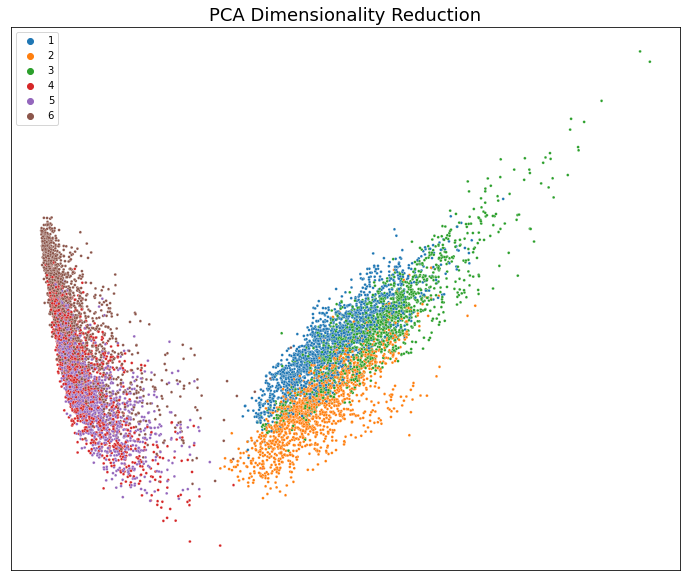

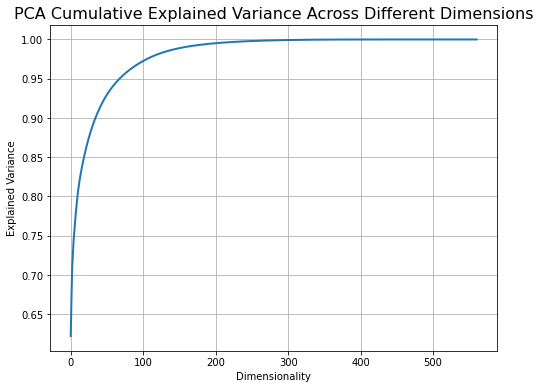

In [25]:
data_sliced = data.head(param_limit_rows_pca).values
labels_sliced = labels.head(param_limit_rows_pca).values

reduce_dimensionality(data=data_sliced, labels=labels_sliced, reducer=Reducer.PCA, config=pca_config)

#### Visualize TSNE dimensionality reduction

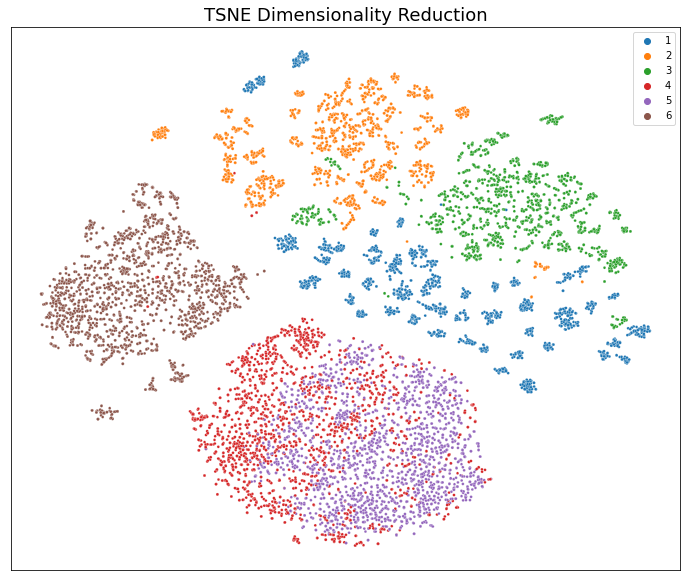

In [26]:
data_sliced= data.head(param_limit_rows_tsne).values
labels_sliced = labels.head(param_limit_rows_tsne).values

reduce_dimensionality(data=data_sliced, labels=labels_sliced, reducer=Reducer.TSNE, config=tsne_config)

#### Visualize UMAP dimensionality reduction

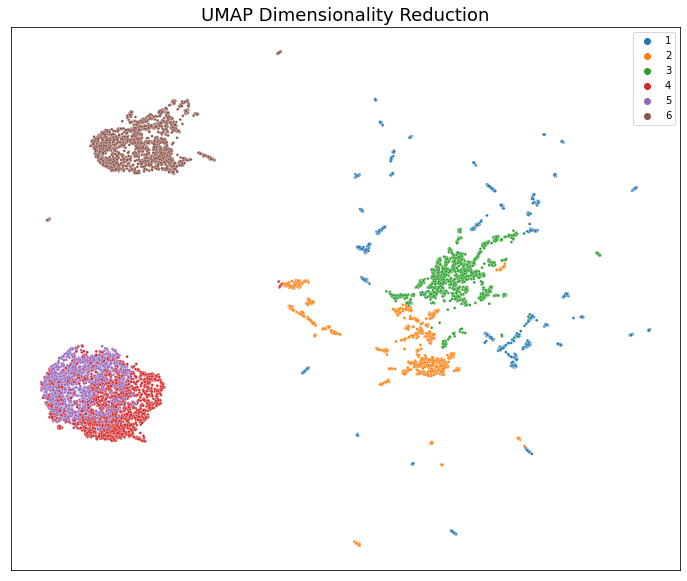

In [27]:
data_sliced= data.head(param_limit_rows_umap).values
labels_sliced = labels.head(param_limit_rows_umap).values

reduce_dimensionality(data=data_sliced, labels=labels_sliced, reducer=Reducer.UMAP, config=umap_config)

#### Visualize TriMap dimensionality reduction

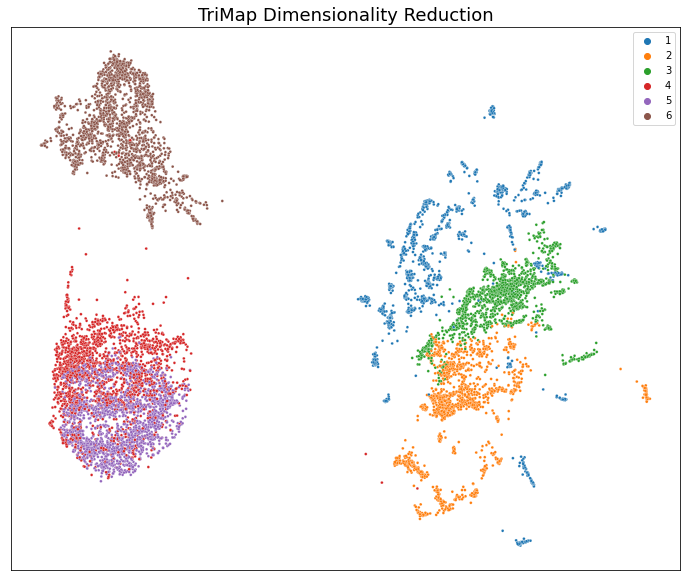

In [28]:
data_sliced= data.head(param_limit_rows_trimap).values
labels_sliced = labels.head(param_limit_rows_trimap).values

reduce_dimensionality(data=data_sliced, labels=labels_sliced, reducer=Reducer.TRIMAP, config=trimap_config)

#### Visualize MDE dimensionality reduction

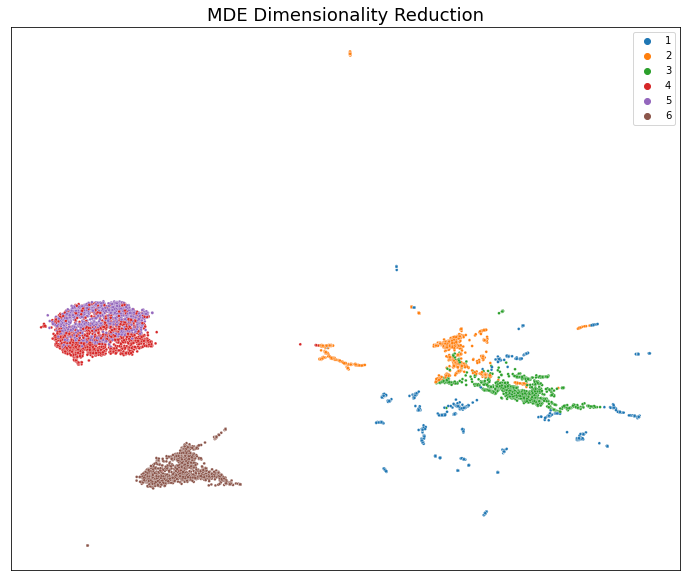

In [29]:
data_sliced= data.head(param_limit_rows_mde).values
labels_sliced = labels.head(param_limit_rows_mde).values

reduce_dimensionality(data=data_sliced, labels=labels_sliced, reducer=Reducer.MDE, config=mde_config)